# Computing Deep Features for Price Prediction on House Shares

Computing Deep Features using GoogLeNet on house share images.

### 1. Setup

* First, set up Python, `numpy`, and `matplotlib`.

In [4]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* Load `caffe`. Might need to run twice to clear errors.

In [7]:
import sys
caffe_root = '/home/adam/src/caffe/'

In [8]:
#%cd /Caffe
sys.path.insert(0, caffe_root + 'python')
import caffe

ImportError: No module named caffe

* If needed, download the reference model, GoogLeNet, inception architecture!

In [5]:
import os 
if os.path.isfile(caffe_root + 'models/bvlc_googlenet/bvlc_googlenet.caffemodel'):
    print 'GoogLeNet found.'
else:
    print 'Downloading pre-trained GoogLeNet model...'
    !scripts/download_model_binary.py models/bvlc_googlenet
    #!../scripts/download_model_binary.py ../models/bvlc_googlenet

/home/adam/src/caffe
GoogLeNet found.


### 2. Load net and set up input preprocessing

* Set Caffe to CPU mode and load the net from disk.

In [6]:
caffe.set_mode_cpu()

model = "bvlc_googlenet"
model_def = caffe_root + 'models/' + model +'/deploy.prototxt'
model_weights = caffe_root + 'models/' + model + '/' + model + '.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)


* Set up input preprocessing. (We'll use Caffe's `caffe.io.Transformer` to do this, but this step is independent of other parts of Caffe, so any custom preprocessing code may be used). Our default CaffeNet is configured to take images in BGR format. Values are expected to start in the range [0, 255] and then have the mean ImageNet pixel value subtracted from them. In addition, the channel dimension is expected as the first (_outermost_) dimension. As matplotlib will load images with values in the range [0, 1] in RGB format with the channel as the _innermost_ dimension, we are arranging for the needed transformations here.

In [7]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


### 3. CPU classification

* Now we're ready to perform classification. Even though we'll only classify one image, we'll set a batch size of 1 to demonstrate batching.

In [8]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(1,        # batch size
                          3,         # 3-channel (BGR) images
                          224, 224)  # image size is 227x227

* Load an image (that comes with Caffe) and perform the preprocessing we've set up.

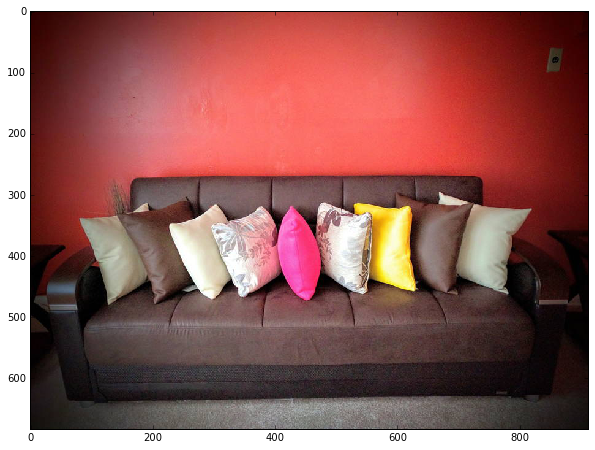

In [9]:
image = caffe.io.load_image('/ABB/Data/Pics/NYC/9999919.jpg')
#mean_image = caffe.io.load_image(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
#image = caffe.io.load_image(caffe_root + 'examples/images/cat.jpg')
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)
#showowransformed image?!

* It's a couch! Let's classify it!

In [10]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

### perform classification
output = net.forward()

output_prob = output['prob'][0]  # the output probability vector for the first image in the batch

print 'predicted class is:', output_prob.argmax()
#print("Vector of probs for the first image is:", output_prob)
print("arg max value is:", output_prob[output_prob.argmax()])

predicted class is: 831
('arg max value is:', 0.90733504)


* The net gives us a vector of probabilities; the most probable class was the 281st one. But is that correct? Let's check the ImageNet labels...

In [11]:
# load ImageNet labels
labels_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
if not os.path.exists(labels_file):
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    
labels = np.loadtxt(labels_file, str, delimiter='\t')

print 'output label:', labels[output_prob.argmax()]

output label: n04344873 studio couch, day bed


* "Studio couch, day bed" is correct! But let's also look at other top (but less confident predictions).

In [13]:
# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]  # reverse sort and take five largest items

print 'probabilities and labels:'
print(zip(output_prob[top_inds], labels[top_inds]))

probabilities and labels:
[(0.90733504, 'n04344873 studio couch, day bed'), (0.012958433, 'n03637318 lampshade, lamp shade'), (0.0092179216, 'n04033995 quilt, comforter, comfort, puff'), (0.0091901664, 'n03529860 home theater, home theatre'), (0.0084439702, 'n03938244 pillow')]


* We see that less confident predictions are somewhat sensible.

### 4. Switching to GPU mode

* Let's see how long classification took, and compare it to GPU mode.

In [14]:
%timeit net.forward()

1 loop, best of 3: 934 ms per loop


* That's a whole sec for our batch of size 1! A while on our blackstone machine with a quad core Intel CPU, even for a batch of images. Let's switch to GPU mode.

In [19]:
caffe.set_device(0)  # if we have multiple GPUs, pick the first one
caffe.set_mode_gpu()
net.forward()  # run once before timing to set up memory
%timeit net.forward()

100 loops, best of 3: 13.9 ms per loop


* That's 13 ms for one forward pass, about a 1000x speedup!

### 5. Examining intermediate output

* A net is not just a black box; let's take a look at some of the parameters and intermediate activations.

First we'll see how to read out the structure of the net in terms of activation and parameter shapes.

* For each layer, let's look at the activation shapes, which typically have the form `(batch_size, channel_dim, height, width)`.

    The activations are exposed as an `OrderedDict`, `net.blobs`.

In [20]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 3, 224, 224)
conv1/7x7_s2	(1, 64, 112, 112)
pool1/3x3_s2	(1, 64, 56, 56)
pool1/norm1	(1, 64, 56, 56)
conv2/3x3_reduce	(1, 64, 56, 56)
conv2/3x3	(1, 192, 56, 56)
conv2/norm2	(1, 192, 56, 56)
pool2/3x3_s2	(1, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_0	(1, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_1	(1, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_2	(1, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_3	(1, 192, 28, 28)
inception_3a/1x1	(1, 64, 28, 28)
inception_3a/3x3_reduce	(1, 96, 28, 28)
inception_3a/3x3	(1, 128, 28, 28)
inception_3a/5x5_reduce	(1, 16, 28, 28)
inception_3a/5x5	(1, 32, 28, 28)
inception_3a/pool	(1, 192, 28, 28)
inception_3a/pool_proj	(1, 32, 28, 28)
inception_3a/output	(1, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_0	(1, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_1	(1, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_2	(1, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_3	(1, 256, 28, 28)


* Now look at the parameter shapes. The parameters are exposed as another `OrderedDict`, `net.params`. We need to index the resulting values with either `[0]` for weights or `[1]` for biases.

    The param shapes typically have the form `(output_channels, input_channels, filter_height, filter_width)` (for the weights) and the 1-dimensional shape `(output_channels,)` (for the biases).

In [21]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1/7x7_s2	(64, 3, 7, 7) (64,)
conv2/3x3_reduce	(64, 64, 1, 1) (64,)
conv2/3x3	(192, 64, 3, 3) (192,)
inception_3a/1x1	(64, 192, 1, 1) (64,)
inception_3a/3x3_reduce	(96, 192, 1, 1) (96,)
inception_3a/3x3	(128, 96, 3, 3) (128,)
inception_3a/5x5_reduce	(16, 192, 1, 1) (16,)
inception_3a/5x5	(32, 16, 5, 5) (32,)
inception_3a/pool_proj	(32, 192, 1, 1) (32,)
inception_3b/1x1	(128, 256, 1, 1) (128,)
inception_3b/3x3_reduce	(128, 256, 1, 1) (128,)
inception_3b/3x3	(192, 128, 3, 3) (192,)
inception_3b/5x5_reduce	(32, 256, 1, 1) (32,)
inception_3b/5x5	(96, 32, 5, 5) (96,)
inception_3b/pool_proj	(64, 256, 1, 1) (64,)
inception_4a/1x1	(192, 480, 1, 1) (192,)
inception_4a/3x3_reduce	(96, 480, 1, 1) (96,)
inception_4a/3x3	(208, 96, 3, 3) (208,)
inception_4a/5x5_reduce	(16, 480, 1, 1) (16,)
inception_4a/5x5	(48, 16, 5, 5) (48,)
inception_4a/pool_proj	(64, 480, 1, 1) (64,)
inception_4b/1x1	(160, 512, 1, 1) (160,)
inception_4b/3x3_reduce	(112, 512, 1, 1) (112,)
inception_4b/3x3	(224, 112, 3, 3) (224

* Since we're dealing with four-dimensional data here, we'll define a helper function for visualizing sets of rectangular heatmaps.

In [23]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

* First we'll look at the first layer filters, `conv1/7x7_s2`

(64, 3, 7, 7)


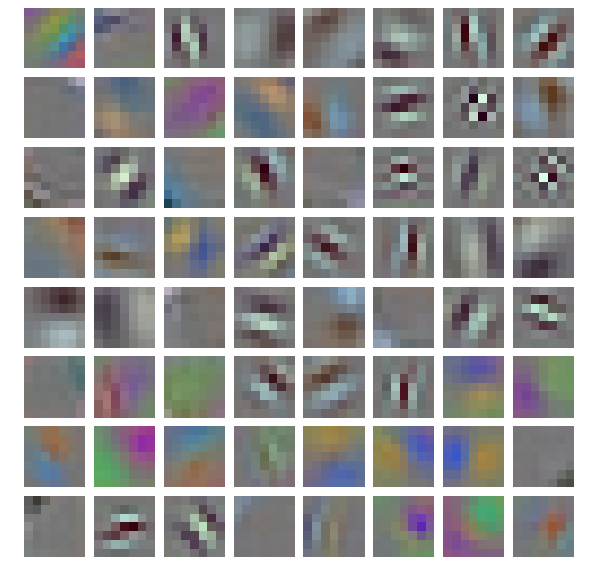

In [26]:
# the parameters are a list of [weights, biases]
print(net.params['conv1/7x7_s2'][0].data.shape)
filters = net.params['conv1/7x7_s2'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

* The first layer output, `conv1` (rectified responses of the filters above, first 36 only)

(1, 64, 112, 112)
(64, 112, 112)


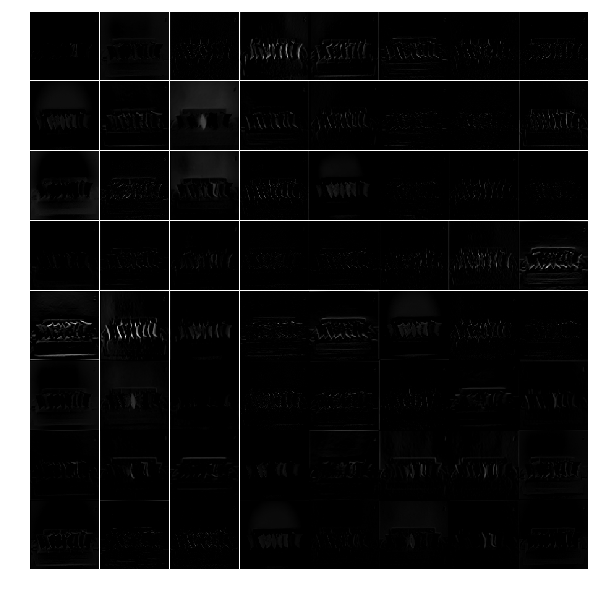

In [28]:
print(net.blobs['conv1/7x7_s2'].data.shape)
feat = net.blobs['conv1/7x7_s2'].data[0]
print(feat.shape)
#feat = net.blobs['conv1'].data[0, :50]
#feat = net.blobs['conv1'].data[0, :36]
vis_square(feat)

* The output of the fifth inception layer, `inception_5a/5x5'

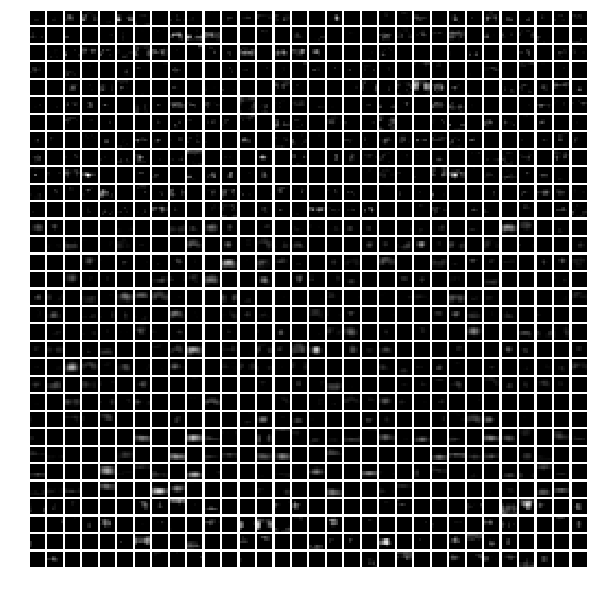

In [44]:
#print(net.blobs['inception_5b/5x5'].data.shape)
#feat = net.blobs['inception_5b/5x5'].data[0, :5]
feat = net.blobs['inception_5b/5x5'].data[0]
feat = net.blobs['inception_5b/pool_proj'].data[0]
feat = net.blobs['inception_5b/output'].data[0]  #<- deep features!
#feat = net.blobs['pool5/7x7_s1'].data[0]
#feat = net.blobs['prob'].data[0]
#print(feat.shape)
#print(feat)
#print(type(feat))
#print(feat[1])
#print(feat)
#These are the deep features just before the fc layers!!
vis_square(feat)
#Save feat to disk
#!pwd
#np.save("/home/adam/CVProjects/AirBnBConvNet/img01", feat, allow_pickle=False)

* We show the output values and the histogram of the positive values

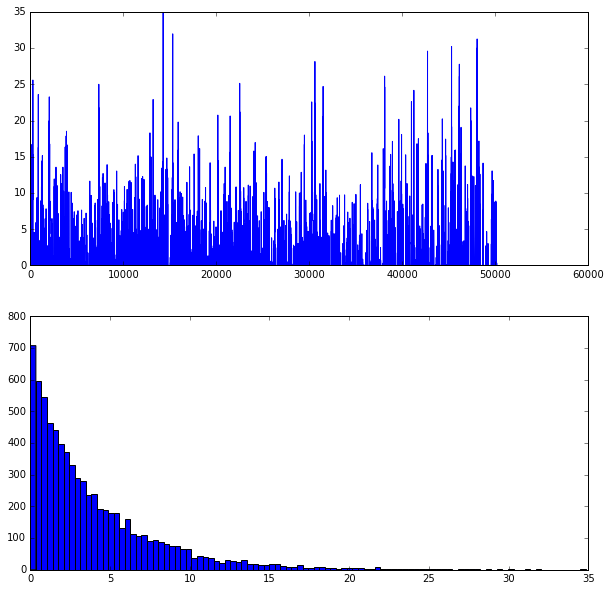

In [49]:
feat = net.blobs['inception_5b/5x5'].data[0]
feat = net.blobs['inception_5b/pool_proj'].data[0]
feat = net.blobs['inception_5b/output'].data[0]  #<- deep features!
#feat = net.blobs['pool5/7x7_s1'].data[0] #<- max pool over deep features
#feat = net.blobs['prob'].data[0] #<- output of everything, one pixel

plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

* The final probability output, `prob`

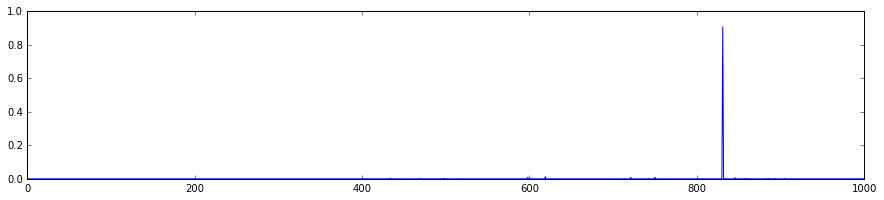

In [50]:
feat = net.blobs['prob'].data[0]
plt.figure(figsize=(15, 3))
plt.plot(feat.flat)

Note the cluster of strong predictions; the labels are sorted semantically. The top peaks correspond to the top predicted labels, as shown above.

### 6. Try your own image

Now we'll grab an image from the web and classify it using the steps above.

* Try setting `my_image_url` to any JPEG image URL.

In [ ]:
# download an image
#my_image_url = "~/Desktop/LON/375799.jpg "  # paste your URL here
# for example:
# my_image_url = "https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG"
# !wget -O image.jpg $my_image_url

import os

cityFp = "LON/"
leftOf = 12805

sourceBaseFp = '/home/adam/CVProjects/AirBnBConvNet/Data/Pics/' + cityFp
def runImage(fp): #fp is absolute file path!
    # transform the image and copy it into the net
    image = caffe.io.load_image(fp)
    net.blobs['data'].data[...] = transformer.preprocess('data', image)
    # perform classification
    net.forward()
    # obtain the output probabilities
    output_prob = net.blobs['prob'].data[0]
    # sort top five predictions from softmax output
    top_inds = output_prob.argsort()[::-1][:5]
    # optionally show the image
    #plt.imshow(image)
    
    ##Save deep feature
    feat = net.blobs['conv5'].data[0]   #These are the deep features just before the fc layers!!
    #print(feat.shape)
    # optionlaly visualize the feature
    #vis_square(feat)
    #Save feat to disk
    fndf = "/home/adam/CVProjects/AirBnBConvNet/DeepFeatures/" + cityFp + fp.split('/')[-1].split('.')[0] + ".npy"
    np.save(fndf, feat, allow_pickle=False)
    print("Saved deep feature at %s" % fndf)
    
    ##Save Probabilites and labels
    l = zip(output_prob[top_inds], labels[top_inds])
    fnprobs = "/home/adam/CVProjects/AirBnBConvNet/DeepProbs/" + cityFp + fp.split('/')[-1].split('.')[0] + ".list"
    #print("fnprobs is %s" % fnprobs)
    with open(fnprobs, 'w') as f:
        for i in l:
            f.write(str(i) + '\n')
        print("Saved prob list at %s" % fnprobs)
    
#Sample run:
#fp = "/home/adam/CVProjects/AirBnBConvNet/Data/Pics/AMS/1000126.jpg
#runImage(fp)


def runImages():
    files = [f for f in os.listdir(sourceBaseFp)]
    for file in files:
        fp = sourceBaseFp + file
        #print(fp)
        runImage(fp)
#%time runImages()

def runImages(n):
  files = [f for f in os.listdir(sourceBaseFp)]
  #print(files)        
  for i in xrange(n, len(files)):
        #print(i)
        fp = sourceBaseFp + files[i]
        runImage(fp)        
runImages(leftOf)
        


In [ ]:
for file in files:
    fp = sourceBaseFp + file
     #print(fp)
     #runImage(fp)
print("Done")

In [ ]:
files = [f for f in os.listdir(sourceBaseFp)]
len(files)
with open('/ABB/files.txt', 'w') as f:
  for file in files:
    f.write(file)
    f.write('\n')
print("Done!")
!pwd
